In [1]:
# To Move into Files...
class Data():
    def __init__(
        self,
        paths_statFiles,
        paths_labelFiles=None,
        um_per_pixel=1.0,
        new_or_old_suite2p='new',
        verbose=True 
                ):
        """
        Initializes the class for importing spatial footprints.
        Args:
            paths_statFiles (list of str or pathlib.Path):
                List of paths to the stat.npy files.
                Elements should be one of: str, pathlib.Path,
                 list of str or list of pathlib.Path
            paths_labelFiles (list of str or pathlib.Path):
                Optional. Only used to train a classifier.
                List of paths to the label .npy files.
                Elements should be one of: str, pathlib.Path,
                 list of str or list of pathlib.Path
            um_per_pixel (float):
                'micrometers per pixel' of the imaging field
                  of view.
            verbose (bool):
                If True, prints results from each function.
        """

        self.paths_stat = fix_paths(paths_statFiles)
        if paths_labelFiles is not None:
            self.paths_lbl = fix_paths(paths_labelFiles)
        else:
            self.paths_lbl = None

        self.n_sessions = len(self.paths_stat)
        self.statFiles = None
        self.labelFiles = None
        self.um_per_pixel = um_per_pixel
        self._new_or_old_suite2p = new_or_old_suite2p
        self._verbose = verbose
        
        return
    
    def import_statFiles(self):
        """
        Imports the stats.npy contents into the class.
        This method can be called before any other function.

        Returns:
            self.statFiles (list):
                List of imported files. Type depends on sf_type.
        """

        print(f"Starting: Importing spatial footprints from stat files") if self._verbose else None

        statFiles_lst = []
        for path_stat in self.paths_stat:
            if Path(path_stat).suffix == '.npz':
                dat = np.load(path_stat)
                images_labeled = scipy.sparse.csr_matrix((dat['data'], dat['indices'], dat['indptr']), shape=dat['shape']).toarray()
                images_labeled = [images_labeled.reshape([-1, 36,36])]

            elif Path(path_stat).suffix == '.npy':
                images_labeled = \
                    helpers.import_multiple_stat_files(   
                        paths_statFiles=[path_stat],
                        out_height_width=[36,36],
                        max_footprint_width=241
                    )
            else:
                raise ValueError(f'path_stat: {path_stat} is not an npy or npz file.')
            
            statFiles_lst.extend(images_labeled)
        
        
        self.n_roi = [len(stat) for stat in statFiles_lst]
        self.n_roi_total = sum(self.n_roi)
        
        self.statFiles = np.concatenate(statFiles_lst,axis=0)
        
        if type(self.labelFiles) is np.ndarray:
            assert self.statFiles.shape[0] == self.labelFiles.shape[0] , 'num images in stat files does not correspond to num labels'

        print(f"Completed: Imported {len(self.statFiles)} stat files into class as self.statFiles. Total number of ROIs: {self.n_roi_total}. Number of ROI from each file: {self.n_roi}") if self._verbose else None
        
        
        return self.statFiles
        
    def import_labelFiles(self):
        """
        Imports the FOV images from ops files or user defined
         image arrays.

        Args:
            type_meanImg (str):
                Type of the mean image.
                References the key in the ops.npy file.
                Options are:
                    'meanImgE':
                        Enhanced mean image.
                    'meanImg':
                        Mean image.
            images (list of np.ndarray):
                Optional. If provided, the FOV images are 
                 defined by these images.
                If not provided, the FOV images are defined by
                 the ops.npy files from self.paths_ops.
                len(images) must be equal to len(self.paths_stat)
                Images must be of the same shape.
        
        Returns:
            self.FOV_images (list):
                List of FOV images.
                Length of the list is the same self.paths_files.
                Each element is a numpy.ndarray of shape:
                 (n_files, height, width)
        """
        
        print(f"Starting: Importing labels footprints from npy files") if self._verbose else None
        
        raw_labels = [np.load(path) for path in self.paths_lbl]
        self.n_lbl = [len(stat) for stat in raw_labels]
        self.n_lbl_total = sum(self.n_roi)
        self.labelFiles = helpers.squeeze_integers(np.concatenate(raw_labels))
        if type(self.statFiles) is np.ndarray:
            assert self.statFiles.shape[0] == self.labelFiles.shape[0] , 'num images in stat files does not correspond to num labels'
                
        print(f"Completed: Imported {len(self.labelFiles)} labels into class as self.labelFiles. Total number of ROIs: {self.n_lbl_total}. Number of ROI from each file: {self.n_lbl}") if self._verbose else None
        
        return self.labelFiles


    def drop_nan_rois(self):
        idx_nne = helpers.get_keep_nonnan_entries(self.statFiles)
        self.statFiles = self.statFiles[idx_nne]
        self.labelFiles = self.labelFiles[idx_nne]
        return self.statFiles, self.labelFiles




        
    def relabeling(self):
#         https://github.com/seung-lab/fastremap

#         # Relabel values based on relabels definition
#         # Used for combining e.g. 4 into 3 via {4: 3}
#         new_labels = fg.relabel(labels, relabels)

#         # Identify the examples to keep by with labels not in the list "lbls_to_drop"
#         # E.g. If all label 6s are bad data to not be classified, pass a list of [6]
#         keep_tf = fg.get_keep_labels(new_labels, lbls_to_drop)


#         # Create a final list of indices that should be kept (for use in filtering both labels and ROI images)
#         idx_toKeep = fg.get_keep_entries(keep_tf)

#         # 
#         idx_nne = fg.get_keep_nonnan_entries(images_labeled_clean)
#         images_labeled_clean = images_labeled_clean[idx_nne]
#         latents_clean = latents_clean[idx_nne]
#         labels_clean = labels_clean[idx_nne]
            
#         # Keep only ROI values that are labelled by not dropped classes
#         images_labeled_clean = raw_images_dup[idx_toKeep]
#         latents_clean = latents_dup[idx_toKeep]
#         labels_clean = labels[idx_toKeep]

#         # Set lowest label value to 0 and sweeze all other label numbers to be sequential integers
#         labels_clean -= labels_clean.min()
#         labels_clean = helpers.squeeze_integers(labels_clean)

#         # 
#         idx_nne = fg.get_keep_nonnan_entries(images_labeled_clean)
#         images_labeled_clean = images_labeled_clean[idx_nne]
#         latents_clean = latents_clean[idx_nne]
#         labels_clean = labels_clean[idx_nne]
            
            return

    
def fix_paths(paths):
    """
    Make sure path_files is a list of pathlib.Path
    
    Args:
        paths (list of str or pathlib.Path or str or pathlib.Path):
            Potentially dirty input.
            
    Returns:
        paths (list of pathlib.Path):
            List of pathlib.Path
    """
    
    
    if (type(paths) is str) or (type(paths) is pathlib.PosixPath):
        paths = [Path(paths)]
    if type(paths[0]) is str:
        paths = [Path(path) for path in paths]
    if type(paths[0]) is pathlib.PosixPath:
        paths = paths
    else:
        raise TypeError("path_files must be a list of str or list of pathlib.Path or a str or pathlib.Path")

    return paths
    
    
# # class ROINet():
# #     def __init__(self):
# #         return
# #         device_dataloader = torch_helpers.set_device(use_GPU=simclr_params_json['useGPU_dataloader'])
# #         DEVICE = torch_helpers.set_device(use_GPU=simclr_params_json['useGPU_training'])

# #         # hash_dict_true={
# #         #             'params': ('params.json', hash_file('/n/data1/hms/neurobio/sabatini/josh/analysis/roinet-paper/debugging/params.json')),
# #         #             'model': ('model.py', hash_file('/n/data1/hms/neurobio/sabatini/josh/analysis/roinet-paper/debugging/model.py')),
# #         #             'state_dict': ('ConvNext_tiny__1_0_unfrozen__simCLR.pth', hash_file('/n/data1/hms/neurobio/sabatini/josh/analysis/roinet-paper/debugging/ConvNext_tiny__1_0_unfrozen__simCLR.pth')),
# #         #         }
# #         # hash_dict_true={
# #         #             'params': ('params.json', hash_file('/n/data1/hms/neurobio/sabatini/josh/analysis/roinet-paper/debugging/params.json')),
# #         #             'model': ('model.py', hash_file('/n/data1/hms/neurobio/sabatini/josh/analysis/roinet-paper/debugging/model.py')),
# #         #             'state_dict': ('ConvNext_tiny__1_0_best__simCLR.pth', hash_file('/n/data1/hms/neurobio/sabatini/josh/analysis/roinet-paper/debugging/ConvNext_tiny__1_0_best__simCLR.pth')),
# #         #         }

# #         ROIne_params = fig_gen_params['ROIne_params']
# #         if 'hash_dict_true' in fig_gen_params:
# #             hash_dict_true = fig_gen_params['hash_dict_true']
# #         else:
# #             hash_dict_true = {}
# #         roinet = ROInet.ROInet_embedder(device=DEVICE, hash_dict_networkFiles=hash_dict_true, **ROIne_params)
# #         # roinet = ROInet.ROInet_embedder(device=DEVICE, hash_dict_networkFiles=hash_dict_true, **ROIne_params)

# #         ROIne_gen_dataloader_params = fig_gen_params['ROIne_gen_dataloader_params']
# #         roinet.generate_dataloader(ROI_images=images_labeled, numWorkers_dataloader=mp.cpu_count(), **ROIne_gen_dataloader_params);

# #         roinet.generate_latents();

# class Embedder():
#     def __init__(self):
#         # Get Embeddings

#         umap_params = dict(
#             n_neighbors=30,
#             n_components=2,
#             metric='euclidean',
#             metric_kwds=None,
#             output_metric='euclidean',
#             output_metric_kwds=None,
#             n_epochs=None,
#             learning_rate=1.0,
#             init='spectral',
#             min_dist=0.1,
#             spread=1.0,
#             low_memory=True,
#             n_jobs=-1,
#             set_op_mix_ratio=1.0,
#             local_connectivity=1.0,
#             repulsion_strength=1.0,
#             negative_sample_rate=5,
#             transform_queue_size=4.0,
#             a=None,
#             b=None,
#             random_state=None,
#             angular_rp_forest=False,
#             target_n_neighbors=-1,
#             target_metric='categorical',
#             target_metric_kwds=None,
#             target_weight=0.5,
#             transform_seed=42,
#             transform_mode='embedding',
#             force_approximation_algorithm=False,
#             verbose=False,
#             tqdm_kwds=None,
#             unique=False,
#             densmap=False,
#             dens_lambda=2.0,
#             dens_frac=0.3,
#             dens_var_shift=0.1,
#             output_dens=False,
#             disconnection_distance=None,
#             precomputed_knn=(None, None, None),
#         )

#         umap = UMAP(**umap_params)
#         embeddings = umap.fit_transform(features_nn)
#         return
#     def fit(self):
        
#         return
#     def transform(self):
        
#         return
#     def fit_transform(self, x):
#         self.fit(x)
#         return self.transform(x)

class Preprocessor():
    
    def __init__(self, use_pca=True, use_zscore=True):
        self.comp_nn = None
        self.scores_nn = None
        self.SVs = None
        self.EVR_nn = None
        self.use_pca = use_pca
        self.use_zscore = use_zscore
    
    # =========================
    
    def fit_transform_preprocess(self, x, rank=None):
        scores = self.fit_transform_pca(x, rank=rank) if self.use_pca else x
        zscores = self.transform_zscore(scores) if self.use_zscore else scores
        return zscores
        
    def transform_preprocess(self, x, rank=None):
        scores = self.transform_pca(x, rank=rank) if self.use_pca else x
        zscores = self.transform_zscore(scores) if self.use_zscore else scores
        return zscores
    
    def save_preprocess(self, filename):
        
        return
        
    def load_preprocess(self, filename):
        
        return
    
    # =========================
    
    def fit_transform_pca(self, x, rank=None):
        # PCA
        self.comp_nn, self.scores_nn, self.SVs, self.EVR_nn = helpers.torch_pca(x, zscore=self.use_zscore)
        if rank is None:
            rank = self.scores_nn.shape[1]
        return self.scores_nn[:, :rank]
    
    def transform_pca(self, x, rank=None):
        assert type(self.comp_nn) is np.array or type(self.comp_nn) is torch.Tensor, "Error: PCA must be fit (via fit_transform_pca) before it can be used."
        if rank is None:
            rank = self.scores_nn.shape[1]
        return torch.matmul(x, self.comp_nn[:, :rank])
    
    # =========================
    
    def transform_zscore(self, x):
        zsc = scipy.stats.zscore(x, axis=0)
        zsc = zsc[:, ~torch.isnan(zsc[0,:])]
        zsc = torch.as_tensor(zsc, dtype=torch.float32)
        return zsc

    
class Classifier():
    
    def __init__(self, preprocessor):
        self.preprocessor = preprocessor
        self.classifier = None
        return
    
    # =========================
    
    def fit_classifier(self, x, y, rank=None, max_iter=10000, C=1):
        pp_x = self.preprocessor.fit_transform_preprocess(x, rank=rank)
        self.classifier = self.logreg_classifier(pp_x, y, max_iter=max_iter, C=C)
    
    def classify(self, x):
        pp_x = self.preprocessor.transform_preprocess(x)
#         self.classifier = self.logreg_predict(pp_x)
        return self.logreg_predict(x)
    
    def save_classifier(self):
        # TODO: Complete
        return
        
    def load_classifier(self):
        # TODO: Complete
        return
        
    # =========================
    
    def logreg_classifier(self, x, y, **kwargs):
        """
        Fit a logistic regression classifier to the training data
        X_eval: Head from which to classify examples
        y_eval: True labels for examples for evaluation
        counts: Whether to return confusion matrix as counts (False) or percentages (True)
        github_loc: Location which cincludes basic_nerual_processing_modules
        """
        logreg = sklearn.linear_model.LogisticRegression(
                solver='lbfgs',
                fit_intercept=True, 
                class_weight='balanced',
                **kwargs
        )
        logreg.fit(x, y)
        return logreg  
    
    def logreg_predict(self, x):
        """
        Fit a logistic regression classifier to the training data
        X_eval: Head from which to classify examples
        y_eval: True labels for examples for evaluation
        counts: Whether to return confusion matrix as counts (False) or percentages (True)
        github_loc: Location which cincludes basic_nerual_processing_modules
        """
        proba = self.classifier.predict_proba(x)
        preds = np.argmax(proba, axis=1)
        return proba, preds
    
    
class Evaluation():
    def __init__(self, classifier):
        self.classifier = classifier
        return
    
    def confusion_matrix(self, x, y, counts=False):
        """
        Generate a confusion matrix for the dataset based on the classifier
        logreg: sklearn model with score method
        X_eval: Head from which to classify examples
        y_eval: True labels for examples for evaluation
        counts: Whether to return confusion matrix as counts (False) or percentages (True)
        """
        proba, preds = self.classifier.classify(x)
        cm = helpers.confusion_matrix(preds, y.astype(np.int32), counts=counts)
        return cm
    
    def score_classifier_logreg(self, x, y):
        """
        Generate a classification score for dataset based on the classifier
        logreg: sklearn model with score method
        X_eval: Head from which to classify examples
        y_eval: True labels for examples for evaluation
        """
        acc = self.classifier.score(x, y.astype(np.int32), sample_weight=get_balanced_sample_weights(y.astype(np.int32)))
        return acc
    
    # =========================

class Visualization():
    def __init__(self):
        return
    


# Setup

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: jupyter_launcher
python version: 3.8.12


In [3]:
%load_ext autoreload
%autoreload 2

import importlib.util
import glob
import pathlib
from pathlib import Path
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit
import scipy.stats
import scipy.signal
from kymatio import Scattering2D
import json
import numpy as np
import torchvision
import torch
from tqdm.notebook import tqdm, trange
import sys
import pickle
import pandas as pd
import shutil
import h5py
# import figgen as fg
import sys
import time
import gc

print('Numpy Version:', np.__version__)
# print('TorchVision Version:',torchvision.__version__)

dir_github = Path(r'/n/data1/hms/neurobio/sabatini/josh/github_repos/').resolve()

import sys
sys.path.append(str(dir_github))
%load_ext autoreload
%autoreload 2
from ROICaT.tracking import data_importing, visualization, alignment, blurring, helpers, ROInet, scatteringWaveletTransformer, similarity_graph, clustering
import multiprocessing as mp

Numpy Version: 1.21.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
tic = time.time()
toc = {}
toc['start'] = time.time() - tic

# Import Paths

In [5]:
def spr(*directory_list):
    for dir_num, directory in enumerate(directory_list):
        if dir_num == 0:
            full_directory = Path(directory)
        else:
            full_directory = full_directory / directory
    return str(full_directory.resolve())

In [6]:
def print_list(l):
    for item in l:
        print(item)

In [7]:
# dir_allOuterFolders = Path(r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16").resolve()
# # dir_allOuterFolders = Path(r"/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files").resolve()

# folders_allSessions = natsort.natsorted(helpers.get_dir_contents(dir_allOuterFolders)[0])

# dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_allSessions]

# pathSuffixToStat = 'plane0/stat.npy'
# pathSuffixToOps = 'plane0/ops.npy'
# # pathSuffixToStat = 'stat.npy'
# # pathSuffixToOps = 'ops.npy'

# paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:]
# paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:]
# # paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])
# # paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])

# print(f'folder names of all sessions: \n{folders_allSessions}')
# print(f'paths to all stat files: \n{paths_allStat}')


# ---------------------------------------
# || Specify Raw Data Filename Sources ||
# ---------------------------------------
stat_files = spr('/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/stat.npy')
label_files = spr('/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/labels_round2_sesh2.npy')

# Import Data

In [8]:
data = Data(
    paths_statFiles=stat_files,
    paths_labelFiles=label_files,
    um_per_pixel=1.0,
    verbose=True,
)

data.import_statFiles();
data.import_labelFiles();

# data.import_ROI_spatialFootprints(workers=-1);

Starting: Importing spatial footprints from stat files
Completed: Imported 4898 stat files into class as self.statFiles. Total number of ROIs: 4898. Number of ROI from each file: [4898]
Starting: Importing labels footprints from npy files
Completed: Imported 4898 labels into class as self.labelFiles. Total number of ROIs: 4898. Number of ROI from each file: [4898]


In [9]:
# %matplotlib notebook

# # From ROICaT
# visualization.display_toggle_image_stack(np.concatenate(data.ROI_images, axis=0))

In [10]:
toc['import_data'] = time.time() - tic

# Concatenate / Adjust / Clean Data + Drop Non-Nans

In [11]:
data.drop_nan_rois();

# Neural Network Embeddings

In [12]:
hash_dict_true = {
    'params': ('params.json', '68cf1bd47130f9b6d4f9913f86f0ccaa'),
    'model': ('model.py', '61c85529b7aa33e0dfadb31ee253a7e1'),
    'state_dict': ('ConvNext_tiny__1_0_best__simCLR.pth', '3287e001ff28d07ada2ae70aa7d0a4da'),
}

roinet = ROInet.ROInet_embedder(
    device='cuda:0',
#     dir_networkFiles='/home/rich/Downloads/ROInet',
    dir_networkFiles='/n/data1/hms/neurobio/sabatini/josh/analysis/roinet-paper/ROICaT',
    
#     download_from_gDrive='force_download',
#     download_from_gDrive='force_local',
    download_from_gDrive='check_local_first',
    gDriveID='1D2Qa-YUNX176Q-wgboGflW0K6un7KYeN',
    hash_dict_networkFiles=hash_dict_true,
#     hash_dict_networkFiles=None,
    forward_pass_version='latent',
    verbose=True,
)

roinet.generate_dataloader(
    ROI_images=[data.statFiles],
    um_per_pixel=data.um_per_pixel,
    pref_plot=False,
    batchSize_dataloader=8,
    pinMemory_dataloader=True,
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=True,
    prefetchFactor_dataloader=2,    
);

roinet.generate_latents();

# roinet.latents
# roinet.dataset
# roinet.net
# roinet.params_model

Successful hash comparison. Found matching files: {'params': '/n/data1/hms/neurobio/sabatini/josh/analysis/roinet-paper/ROICaT/params.json', 'model': '/n/data1/hms/neurobio/sabatini/josh/analysis/roinet-paper/ROICaT/model.py', 'state_dict': '/n/data1/hms/neurobio/sabatini/josh/analysis/roinet-paper/ROICaT/ConvNext_tiny__1_0_best__simCLR.pth'}
Imported model from /n/data1/hms/neurobio/sabatini/josh/analysis/roinet-paper/ROICaT/model.py
Loaded params_model from /n/data1/hms/neurobio/sabatini/josh/analysis/roinet-paper/ROICaT/params.json
Generated network using params_model
Loaded state_dict into network from /n/data1/hms/neurobio/sabatini/josh/analysis/roinet-paper/ROICaT/ConvNext_tiny__1_0_best__simCLR.pth
Loaded network onto device cuda:0
Starting: resizing ROIs


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]
/home/joz608/.conda/envs/jupyter_launcher/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 48 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader
starting: running data through network


100%|██████████| 613/613 [00:12<00:00, 47.49it/s]

completed: running data through network


In [13]:
latents = np.array(roinet.latents)

In [14]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [15]:
toc['NN'] = time.time() - tic

# UMAP Embeddings

In [16]:
umap_params = dict(
    n_neighbors=30,
    n_components=2,
    metric='euclidean',
    metric_kwds=None,
    output_metric='euclidean',
    output_metric_kwds=None,
    n_epochs=None,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    low_memory=True,
    n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    a=None,
    b=None,
    random_state=None,
    angular_rp_forest=False,
    target_n_neighbors=-1,
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding',
    force_approximation_algorithm=False,
    verbose=False,
    tqdm_kwds=None,
    unique=False,
    densmap=False,
    dens_lambda=2.0,
    dens_frac=0.3,
    dens_var_shift=0.1,
    output_dens=False,
    disconnection_distance=None,
    precomputed_knn=(None, None, None),
)

umap = UMAP(**umap_params)
print('Fitting UMAP...')
umap.fit(latents)
print('Generating Embeddings...')
embeddings = umap.transform(latents)
print('Embeddings Generated...')

Fitting UMAP...
Generating Embeddings...
Embeddings Generated...


# Visualize Embeddings

In [17]:
roinet.latents.shape, data.labelFiles.shape

(torch.Size([4898, 128]), (4898,))

<IPython.core.display.Javascript object>


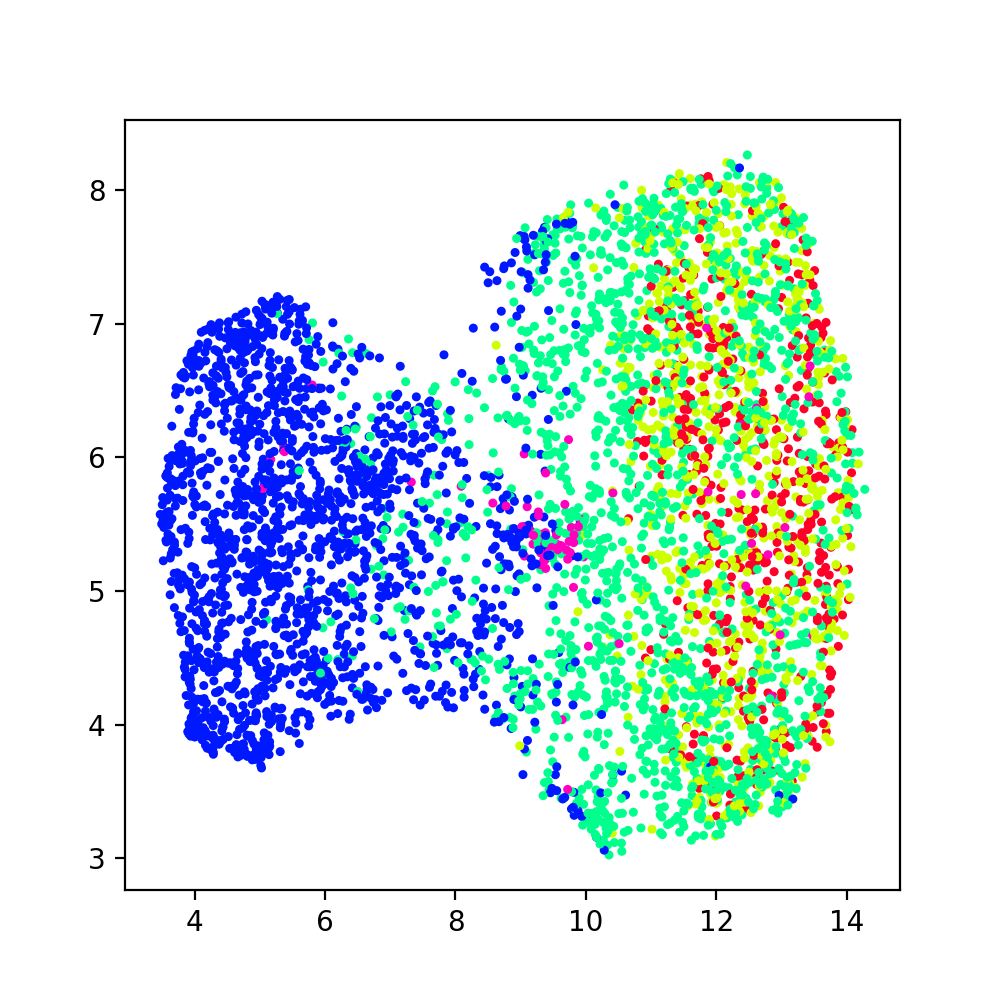

In [18]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(embeddings[:,0], embeddings[:,1], s=5, c=data.labelFiles[:], cmap='gist_rainbow')

In [19]:
toc['visualize'] = time.time() - tic

# Load / Setup Classifier — ZScore + PCA

In [20]:
preprocessor = Preprocessor()
#
preprocessor.fit_transform_preprocess(latents);

/home/joz608/.conda/envs/jupyter_launcher/lib/python3.8/site-packages/scipy/stats/stats.py:2555: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  z[np.broadcast_to(isconst, z.shape)] = np.nan


In [25]:
classifier = Classifier(preprocessor)
classifier.fit_classifier(latents, data.labelFiles)

In [ ]:
evaluator = Evaluation(classifier)
evaluator.confusion_matrix(latents, data.labelFiles)

In [ ]:
# # features_nn = torch.cat(tmp_arr, dim=0)

# features_nn = latents_clean

# # prv_features_nn = features_nn.numpy().copy()

# features_nn_z = scipy.stats.zscore(features_nn, axis=0)
# features_nn_z = features_nn_z[:, ~np.isnan(features_nn_z[0,:])]
# features_nn_z = torch.as_tensor(features_nn_z, dtype=torch.float32)

# # # PCA
# comp_nn, scores_nn, SVs, EVR_nn = decomposition.torch_pca(features_nn, zscore=False)
# # scores_nn = features_nn

# # Normalize PCA'd Values
# features_norm = torch.cat([_ / torch.std(_, dim=0).mean() for _ in [scores_nn]], dim=1)
# # features_norm = scores_nn

## Train/Holdout Split

In [ ]:
# # Train/Holdout Split
# features_train, features_holdout, labels_train, labels_holdout = sklearn.model_selection.train_test_split(features_norm, labels_clean[:features_norm.shape[0]], test_size=0.3)



## Shuffle Split

In [ ]:
# # Shuffle Split
# splitter = ShuffleSplit(n_splits=classifier_n_splits)
# all_split_inx = list(splitter.split(features_train))

## Train'/Val Extract

In [ ]:
# # # Train'/Val Extract
# trainp_X = [features_train[_[0]] for _ in all_split_inx]
# val_X = [features_train[_[1]] for _ in all_split_inx]
# trainp_y = [labels_train[_[0]] for _ in all_split_inx]
# val_y = [labels_train[_[1]] for _ in all_split_inx]

## Fit Classifier

In [ ]:
# # Sweep through regularizations for classifier
# for ic, c in enumerate(C_toUse):
#     cm_trp_lst = []
#     cm_val_lst = []

#     cm_trp_cnt_lst = []
#     cm_val_cnt_lst = []

#     acc_trp_lst = []
#     acc_val_lst = []

#     # Sweep Through Shuffle Splits
#     # trp = Train' or train within single Shuffle Split fold
#     # val = Validation or test set within single Shuffle Split fold
#     for inx_split in trange(len(trainp_X)):
#         tmp_trainp_X = trainp_X[inx_split]
#         tmp_trainp_y = trainp_y[inx_split]

#         tmp_val_X = val_X[inx_split]
#         tmp_val_y = val_y[inx_split]

#         logreg = fg.fit_classifier_logreg(tmp_trainp_X, tmp_trainp_y, max_iter=logistic_max_iter, C=c)

#         cm_trp = fg.cm_classifier_logreg(logreg, tmp_trainp_X, tmp_trainp_y, github_loc=fig_gen_params['github_loc'])
#         cm_val = fg.cm_classifier_logreg(logreg, tmp_val_X, tmp_val_y, github_loc=fig_gen_params['github_loc'])

#         cm_trp_cnt = fg.cm_classifier_logreg(logreg, tmp_trainp_X, tmp_trainp_y, counts=True, github_loc=fig_gen_params['github_loc'])
#         cm_val_cnt = fg.cm_classifier_logreg(logreg, tmp_val_X, tmp_val_y, counts=True, github_loc=fig_gen_params['github_loc'])

#         acc_trp = fg.score_classifier_logreg(logreg, tmp_trainp_X, tmp_trainp_y)
#         acc_val = fg.score_classifier_logreg(logreg, tmp_val_X, tmp_val_y)

#         cm_trp_lst.append(cm_trp)
#         cm_val_lst.append(cm_val)

#         cm_trp_cnt_lst.append(cm_trp_cnt)
#         cm_val_cnt_lst.append(cm_val_cnt)

#         acc_trp_lst.append(acc_trp)
#         acc_val_lst.append(acc_val)
    
    
#     cm_trp_mn = np.mean(cm_trp_lst,axis=0)
#     cm_val_mn = np.mean(cm_val_lst,axis=0)

#     cm_trp_cnt_sm = np.sum(cm_trp_cnt_lst,axis=0)
#     cm_val_cnt_sm = np.sum(cm_val_cnt_lst,axis=0)

#     # Refitting model to all of training / CV data and evaluating on heldout data
#     logreg_refit = fg.fit_classifier_logreg(features_train, labels_train, max_iter=logistic_max_iter, C=c)

#     cm_tr = fg.cm_classifier_logreg(logreg_refit, features_train, labels_train, counts=False, github_loc=fig_gen_params['github_loc'])
#     cm_ho = fg.cm_classifier_logreg(logreg_refit, features_holdout, labels_holdout, counts=False, github_loc=fig_gen_params['github_loc'])

#     cm_tr_cnt = fg.cm_classifier_logreg(logreg_refit, features_train, labels_train, counts=True, github_loc=fig_gen_params['github_loc'])
#     cm_ho_cnt = fg.cm_classifier_logreg(logreg_refit, features_holdout, labels_holdout, counts=True, github_loc=fig_gen_params['github_loc'])

#     acc_tr = fg.score_classifier_logreg(logreg_refit, features_train, labels_train)
#     acc_ho = fg.score_classifier_logreg(logreg_refit, features_holdout, labels_holdout)
    
#     restricted_n_train_results = {}
#     for n_train in n_train_to_use:
#         print('Saving: n_train',n_train)
#         train_size = n_train/features_train.shape[0] if type(n_train) == type(None) and n_train < features_train else None
#         print('Saving: train_size',train_size)
#         if train_size is not None:
#             # Refitting model to n_train data points from training data / and evaluating on heldout data
#             sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size)
#             train_subset_inx, _ = sss.split(features_train, labels_train)[0]
#             features_train_subset, labels_train_subset = features_train[train_subset_inx], labels_train[train_subset_inx]
            
#             logreg_refit = fg.fit_classifier_logreg(features_train_subset, labels_train_subset, max_iter=logistic_max_iter, C=c)
            
#             restricted_n_train_results[f'acc_tr_subset_{n_train}'] = fg.score_classifier_logreg(logreg_refit, features_train_subset, labels_train_subset)
#             restricted_n_train_results[f'acc_tr_{n_train}'] = fg.score_classifier_logreg(logreg_refit, features_train, labels_train)
#             restricted_n_train_results[f'acc_ho_{n_train}'] = fg.score_classifier_logreg(logreg_refit, features_holdout, labels_holdout)
    
#     with h5py.File(fig_gen_params['h5_out_name'], 'a') as f:
#         g = f.create_group(f'creg_{c}')
#         g.attrs['acc_tr'] = np.mean(acc_tr)
#         g.attrs['acc_trp'] = np.mean(acc_trp_lst)
#         g.attrs['acc_val'] = np.mean(acc_val_lst)
#         g.attrs['acc_ho'] = np.mean(acc_ho)
        
#         for n_train in n_train_to_use:
#             print('Saving: n_train',n_train)
#             train_size = n_train/features_train.shape[0] if type(n_train) == type(None) and n_train < features_train else None
#             print('Saving: train_size',train_size)
#             if train_size is not None:
#                 g.attrs[f'acc_tr_subset_{n_train}'] = restricted_n_train_results[f'acc_tr_subset_{n_train}']
#                 g.attrs[f'acc_tr_{n_train}'] = restricted_n_train_results[f'acc_tr_{n_train}']
#                 g.attrs[f'acc_ho_{n_train}'] = restricted_n_train_results[f'acc_ho_{n_train}']

#         gg = g.create_group(f'cm_prc')

#         gg.create_dataset(f'tr', data=cm_tr)
#         gg.create_dataset(f'trp', data=cm_trp_mn)
#         gg.create_dataset(f'val', data=cm_val_mn)
#         gg.create_dataset(f'ho', data=cm_ho)

#         gg = g.create_group(f'cm_count')

#         gg.create_dataset(f'tr', data=cm_tr_cnt)
#         gg.create_dataset(f'trp', data=cm_trp_cnt_sm)
#         gg.create_dataset(f'val', data=cm_val_cnt_sm)
#         gg.create_dataset(f'ho', data=cm_ho_cnt)

#         gg = g.create_group(f'logreg_model')

#         gg.create_dataset(f'coef', data=logreg_refit.coef_)
#         gg.create_dataset(f'int', data=logreg_refit.intercept_)
    
    

## Save Results

In [ ]:
# dir_save = Path('/home/rich/Desktop/').resolve()
dir_save = Path('/n/data1/hms/neurobio/sabatini/josh/analysis/roinet-paper/ROICaT/output/').resolve()
name_save = dir_allOuterFolders.name
path_save = dir_save / (name_save + '.ROICaT.results' + '.pkl')

ROIs = {
    "ROIs_aligned": aligner.ROIs_aligned,
    "ROIs_raw": data.spatialFootprints,
    "frame_height": data.FOV_height,
    "frame_width": data.FOV_width,
    "idx_roi_session": np.where(data.sessionID_concat)[1]
}

results = {
    "UCIDs": labels,
    "UCIDs_bySession": labels_bySession,
    "ROIs": ROIs,
}

helpers.simple_save(
    obj=results,
    filename=path_save,
    mkdir=True,
)

In [ ]:
toc['saving'] = time.time() - tic

In [ ]:
toc

In [ ]:
# Sweep through regularizations for classifier

    # Sweep Through Shuffle Splits

    # Refitting model to all of training / CV data and evaluating on heldout data

            # Refitting model to n_train data points from training data / and evaluating on heldout data
